# Neural networks 101
In this notebook you implement the forward and backward pass in a neural network. We assume that you all ready know backpropagation if you dont have a look at this page [INSERT LINK TO GOOD DERIVATION OF BACKPROP]. 

At first the backward pass in a neural network may seem very complicated. All major neural network libraries (Torch, Caffe, Theano, deeppy) handles this by mechanically applying the chain rule of differentiation and thus breaking up the problem.

First let's load the MNIST dataset and plot a few examples:

In [2]:
import matplotlib
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
from confusionmatrix import ConfusionMatrix

In [3]:
def onehot(t, num_classes):
    out = np.zeros((t.shape[0], num_classes))
    for row, col in enumerate(t):
        out[row, col] = 1
    return out

data = np.load('mnist.npz')
num_classes = 10
x_train = data['X_train']
targets_train = data['y_train']
targets_train = onehot(targets_train, num_classes)

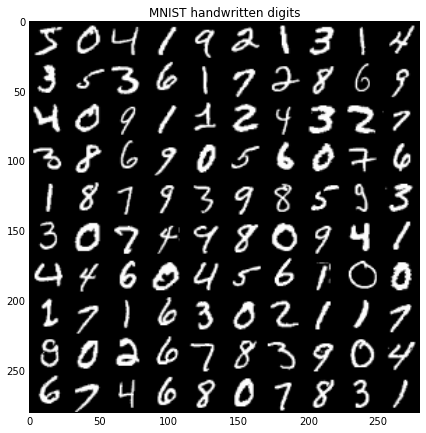

In [4]:
idx = 0
canvas = np.zeros((28*10, 10*28))
for i in range(10):
    for j in range(10):
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = x_train[idx].reshape((28, 28))
        idx += 1
plt.figure(figsize=(7, 7))
plt.imshow(canvas, cmap='gray')
plt.title('MNIST handwritten digits')
plt.show()


# Writing a linear layer

In [5]:
class LinearLayer():
    def __init__(self, num_inputs, num_units, scale=0.01):
        self.W = np.random.random((num_inputs, num_units)) * scale

    def fprop(self, x):
        self.x = x
        self.a = np.dot(x, self.W)
        return self.a

    def bprop(self, delta_in):
        x_t = np.transpose(self.x)
        self.grad = np.dot(x_t, delta_in)

        W_T = np.transpose(self.W)
        self.delta_out = np.dot(delta_in,W_T)
        return self.delta_out

    def update_params(self, lr):
        self.W = self.W - self.grad*lr

# Writing activation function layers

In [6]:
class SigmoidActivationLayer():
    def fprop(self, x):
        self.a = 1.0 / (1+np.exp(-x))
        return self.a

    def bprop(self, delta_in):
        delta_out = self.a * (1 - self.a)*delta_in
        return delta_out

    def update_params(self, lr):
        pass


class ReluActivationLayer():
    def fprop(self, x):
        self.a = np.maximum(0, x)
        return self.a

    def bprop(self, delta_in):
        return delta_in * (self.a > 0).astype(self.a.dtype)

    def update_params(self, lr):
        pass


class IdentityLayer():
    def fprop(self, x):
        return x

    def bprop(self, delta_in):
        return delta_in

    def update_params(self, lr):
        pass

class DropoutLayer():
    def __init__(self, p=0.5):
        self.p = p

    def fprop(self, x, train=True):
        if train:
            mask = np.random.random(x.shape) > (1-self.p)
            self.a = x*mask
            return self.a
        else:
            scale = 1.0 / self.p  # p=1 drop nothing -> no scaling
            return self.a * scale

    def bprop(self, delta_in):
        delta_out = delta_in*self.a
        return delta_out

    def update_params(self, lr):
        pass


class SoftmaxActivationLayer():
    def fprop(self, x):
        x_exp = np.exp(x)
        normalizer = x_exp.sum(axis=-1, keepdims=True)
        self.a = x_exp / normalizer
        return self.a

    def bprop(self, delta_in):
        return delta_in

    def update_params(self, lr):
        pass

# Loss layers
Loss layers are slightly different because they take both prediction probabilities and true targets as output. Many different loss layers exists. Here we implemnt squared loss and cross entropy loss. 


1. For regression problems use a linear output (LinearLayer or IdentityActivationLayer) and SquaredError loss
2. For classification problems use a SoftmaxLayer as output and CrossEntropyLoss

In [7]:
class MeanSquaredLoss():
    def fprop(self, x, t):
        num_batches = x.shape[0]
        cost = 0.5 * (x-t)**2 / num_batches
        return np.mean(np.sum(cost, axis=-1))

    def bprop(self, y, t):
        delta_out = y-t
        return delta_out

    def update_params(self):
        pass


class CrossEntropyLoss():
    def fprop(self, x, t):
        tol = 1e-8
        return np.mean(np.sum(-t * np.log(x + tol), axis=-1))

    def bprop(self, y, t):
        delta_out = y-t
        return delta_out

    def update_params(self):
        pass

#Setting up the model

Because we have implemented the layers with a forward pass (`fprop`) and a backward pass (`bprop`) we only need to setup the layers and connect them

In [8]:
num_samples, num_inputs = x_train.shape
num_hidden_units = 100

l_hid_pre1 = LinearLayer(num_inputs, num_hidden_units)
l_hid_act1 = ReluActivationLayer()
l_drp      = IdentityLayer()
l_hid_pre2 = LinearLayer(num_hidden_units, num_classes)
l_hid_act2 = SoftmaxActivationLayer()

LossLayer = CrossEntropyLoss()


def forward(x):
    out_hid_pre1 = l_hid_pre1.fprop(x)
    out_hid_act1 = l_hid_act1.fprop(out_hid_pre1)
    out_drp      = l_drp.fprop(out_hid_act1)
    out_hid_pre2 = l_hid_pre2.fprop(out_drp)
    y_probs = l_hid_act2.fprop(out_hid_pre2)
    return y_probs


def backward(y_probs, targets):
    delta1 = LossLayer.bprop(y_probs, targets)
    delta2 = l_hid_act2.bprop(delta1)
    delta3 = l_hid_pre2.bprop(delta2)
    delta_drop = l_drp.bprop(delta3)
    delta4 = l_hid_act1.bprop(delta_drop)
    delta5 = l_hid_pre1.bprop(delta4)

def update(learning_rate):
    l_hid_pre1.update_params(learning_rate)
    l_hid_pre2.update_params(learning_rate)
    

# Writing the training loop


In [10]:
batch_size = 200
num_epochs = 10
learning_rate = 0.001
num_samples = x_train.shape[0]
num_batches = num_samples // batch_size


acc = []
for epoch in range(num_epochs):
    confusion = ConfusionMatrix(num_classes)
    for i in range(num_batches):
        idx = range(i*batch_size, (i+1)*batch_size)
        x_batch = x_train[idx]
        target_batch = targets_train[idx]

        y_probs = forward(x_batch)
        loss = LossLayer.fprop(y_probs, target_batch)
        backward(y_probs, target_batch)
        update(learning_rate)
        confusion.batch_add(target_batch.argmax(-1), y_probs.argmax(-1))
    curr_acc = confusion.accuracy()
    print "Epoch %i : Loss %f Train acc %f" % (epoch, loss, curr_acc)
    acc += [curr_acc]

Epoch 0 : Loss 0.203974 Train acc 0.969940
Epoch 1 : Loss 0.194636 Train acc 0.972600
Epoch 2 : Loss 0.183351 Train acc 0.974520
Epoch 3 : Loss 0.171311 Train acc 0.976160
Epoch 4 : Loss 0.160798 Train acc 0.977900
Epoch 5 : Loss 0.149258 Train acc 0.979600
Epoch 6 : Loss 0.140528 Train acc 0.980920
Epoch 7 : Loss 0.131263 Train acc 0.982140
Epoch 8 : Loss 0.123100 Train acc 0.983120
Epoch 9 : Loss 0.115705 Train acc 0.984120


  ------------------------------------------------------
 0 | 4853    0    7    7    4   10   22    3   22    4 |4932
 1 |    1 5576   32   12    7    3    1    9   29    8 |5678
 2 |   16   26 4802   23   17    5   16   36   21    6 |4968
 3 |    8   13   49 4853    2   62    7   36   45   26 |5101
 4 |    6   12   15    1 4692    2   32    5   10   84 |4859
 5 |   14   14    8   51   12 4321   27    7   35   17 |4506
 6 |   23   11    5    2   16   21 4855    0   18    0 |4951
 7 |    5   15   44    4   29    3    2 5018   10   45 |5175
 8 |   13   54   13   42   13   34   24    6 4619   24 |4842
 9 |   16   12    2   24   72   16    2   41   20 4783 |4988
  ------------------------------------------------------
     4955 5733 4977 5019 4864 4477 4988 5161 4829 4997



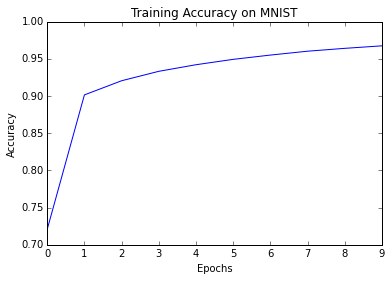

In [26]:
print confusion
plt.plot(range(num_epochs), acc)
plt.title('Training Accuracy on MNIST')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
